# Your First RAQA Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAQA application. 

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

Let's look at a rather complicated looking visual representation of a basic RAQA application.

<img src="https://i.imgur.com/PvlaIUO.png" />

### MY RAG FLOW

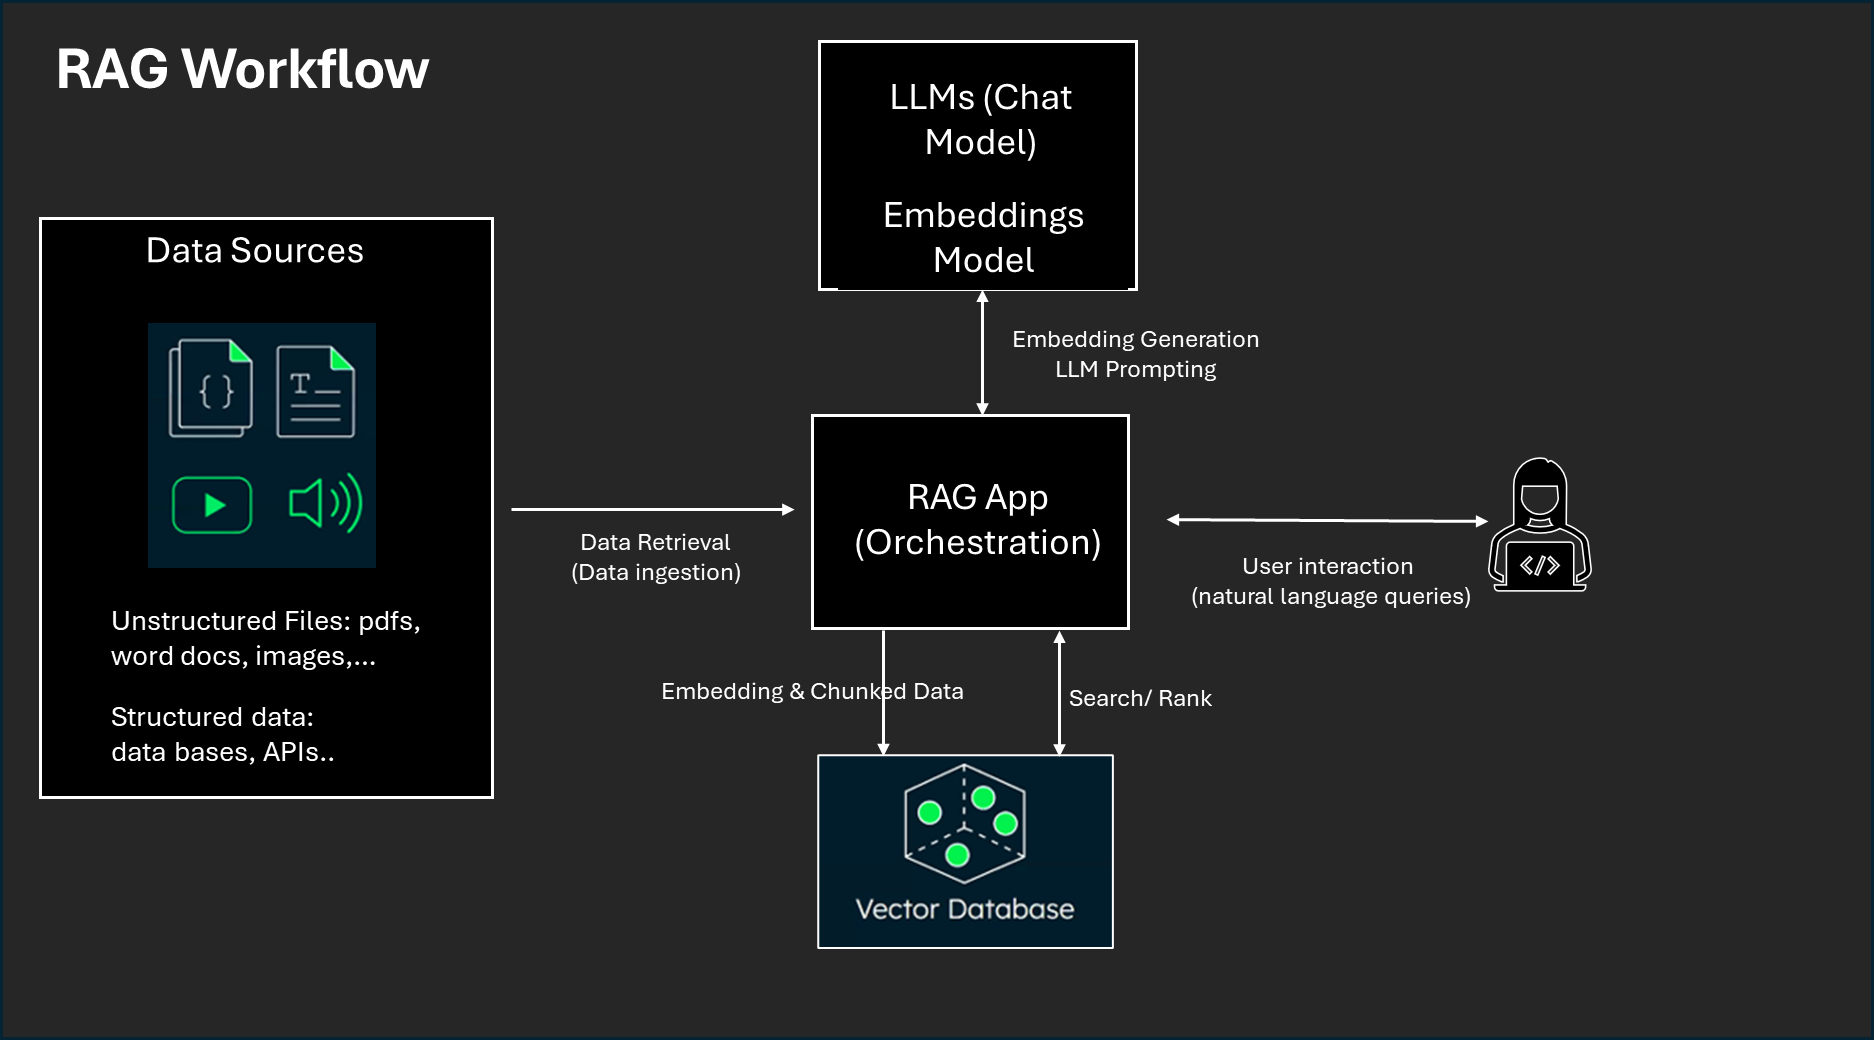

### Imports and Utility 

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [1]:
!pip install -q -U numpy matplotlib plotly pandas scipy scikit-learn openai python-dotenv

In [2]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [3]:
import nest_asyncio
nest_asyncio.apply()

# Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

In [4]:
!pip install PyPDF2

In [11]:
# importing required modules 
from PyPDF2 import PdfReader 
  
# creating a pdf reader object 
reader = PdfReader('sample.pdf') 
  
# printing number of pages in pdf file 
total_pages = len(reader.pages)
print("Total number of pages = ", len(reader.pages)) 
  
# getting a specific page from the pdf file 
page = reader.pages[2] 
  
# extracting text from page 
text = page.extract_text() 
print(text) 


Total number of pages =  10
Contents
1 Template 5
1.1 How tocompilea .texﬁleto a .pdfﬁle. . . . . . . . . . . . . 5
1.1.1 Tools . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5
1.1.2 How to usethetools . . . . . . . . . . . . . . . . . . . . 5
1.2 How towritea document . . . . . . . . . . . . . . . . . . . . . . 6
1.2.1 Themaindocument . . . . . . . . . . . . . . . . . . . . . 6
1.2.2 Chapters . . . . . . . . . . . . . . . . . . . . . . . . . . 6
1.2.3 Spell-checking . . . . . . . . . . . . . . . . . . . . . . . 6
1.3 L ATEXand pdfL ATEXcapabilities . . . . . . . . . . . . . . . . . . . 7
1.3.1 Overview . . . . . . . . . . . . . . . . . . . . . . . . . . 7
1.3.2 L ATEX. . . . . . . . . . . . . . . . . . . . . . . . . . . . 7
1.3.3 pdfL ATEX. . . . . . . . . . . . . . . . . . . . . . . . . . 7
1.3.4 Examples . . . . . . . . . . . . . . . . . . . . . . . . . . 7
3


In [7]:
for page in reader.pages:
    print(page.extract_text())

Sample PDF Document
RobertMaron
Grzegorz Grudzi ´nski
February20, 1999
2
Contents
1 Template 5
1.1 How tocompilea .texﬁleto a .pdfﬁle. . . . . . . . . . . . . 5
1.1.1 Tools . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5
1.1.2 How to usethetools . . . . . . . . . . . . . . . . . . . . 5
1.2 How towritea document . . . . . . . . . . . . . . . . . . . . . . 6
1.2.1 Themaindocument . . . . . . . . . . . . . . . . . . . . . 6
1.2.2 Chapters . . . . . . . . . . . . . . . . . . . . . . . . . . 6
1.2.3 Spell-checking . . . . . . . . . . . . . . . . . . . . . . . 6
1.3 L ATEXand pdfL ATEXcapabilities . . . . . . . . . . . . . . . . . . . 7
1.3.1 Overview . . . . . . . . . . . . . . . . . . . . . . . . . . 7
1.3.2 L ATEX. . . . . . . . . . . . . . . . . . . . . . . . . . . . 7
1.3.3 pdfL ATEX. . . . . . . . . . . . . . . . . . . . . . . . . . 7
1.3.4 Examples . . . . . . . . . . . . . . . . . . . . . . . . . . 7
3
4 CONTENTS
Chapter 1
Template
1.1 How to compilea .texﬁleto a.pdfﬁle
1.

### Loading Source Documents

So, first things first, we need some documents to work with. 

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format. 

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.


In [12]:
text_loader = TextFileLoader("data/KingLear.txt")
documents = text_loader.load_documents()
len(documents)

1

In [13]:
print(documents[0][:100])

ACT I
SCENE I. King Lear's palace.
Enter KENT, GLOUCESTER, and EDMUND
KENT
I thought the king had m


In [14]:
print(documents)

["\ufeffACT I\nSCENE I. King Lear's palace.\nEnter KENT, GLOUCESTER, and EDMUND\nKENT\nI thought the king had more affected the Duke of\nAlbany than Cornwall.\nGLOUCESTER\nIt did always seem so to us: but now, in the\ndivision of the kingdom, it appears not which of\nthe dukes he values most; for equalities are so\nweighed, that curiosity in neither can make choice\nof either's moiety.\nKENT\nIs not this your son, my lord?\nGLOUCESTER\nHis breeding, sir, hath been at my charge: I have\nso often blushed to acknowledge him, that now I am\nbrazed to it.\nKENT\nI cannot conceive you.\nGLOUCESTER\nSir, this young fellow's mother could: whereupon\nshe grew round-wombed, and had, indeed, sir, a son\nfor her cradle ere she had a husband for her bed.\nDo you smell a fault?\nKENT\nI cannot wish the fault undone, the issue of it\nbeing so proper.\nGLOUCESTER\nBut I have, sir, a son by order of law, some year\nelder than this, who yet is no dearer in my account:\nthough this knave came something s

### Splitting Text Into Chunks

As we can see, there is one document - and it's the entire text of Frakenstein

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM. 

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length. 

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following: 
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

Let's take a peek visually at what we're doing here - and why it might be useful:

<img src="https://i.imgur.com/rtM6Ci6.png" />

As you can see (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [15]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

189

Let's take a look at some of the documents we've managed to split.

In [16]:
split_documents[0:1]

["\ufeffACT I\nSCENE I. King Lear's palace.\nEnter KENT, GLOUCESTER, and EDMUND\nKENT\nI thought the king had more affected the Duke of\nAlbany than Cornwall.\nGLOUCESTER\nIt did always seem so to us: but now, in the\ndivision of the kingdom, it appears not which of\nthe dukes he values most; for equalities are so\nweighed, that curiosity in neither can make choice\nof either's moiety.\nKENT\nIs not this your son, my lord?\nGLOUCESTER\nHis breeding, sir, hath been at my charge: I have\nso often blushed to acknowledge him, that now I am\nbrazed to it.\nKENT\nI cannot conceive you.\nGLOUCESTER\nSir, this young fellow's mother could: whereupon\nshe grew round-wombed, and had, indeed, sir, a son\nfor her cradle ere she had a husband for her bed.\nDo you smell a fault?\nKENT\nI cannot wish the fault undone, the issue of it\nbeing so proper.\nGLOUCESTER\nBut I have, sir, a son by order of law, some year\nelder than this, who yet is no dearer in my account:\nthough this knave came something s

### Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format. 

Loosely, this means turning the text into numbers. 

There are plenty of resources that talk about this process in great detail - I'll leave this [blog](https://txt.cohere.com/sentence-word-embeddings/) from Cohere.AI as a resource if you want to deep dive a bit. 

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

While this is all baked into 1 call - let's look at some of the code that powers this process:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model. 

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓QUESTION:

Though 1536 is the default dimension of `text-embedding-3-small`, you can pass a dimension parameter and shorten the vector - what method does OpenAI use to achieve this shortening?

### As part of the embedding create method 

In [18]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [19]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓QUESTION:

What advantage does an async implementation provide for us?
### allows to handle more concurrency and reduce waiting/blocking

So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus. 

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

Default is Cosine similarity or using distance_measure_type = 0, and 1 for Euclidean distance

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [20]:
#vector_db.search_by_text("Your servant Kent. Where is your servant Caius?", k=3,distance_measure_type=0, return_as_text = False)
vector_db.search_by_text("Your servant Kent. Where is your servant Caius?", k=3)

[("ng] O my good master!\nKING LEAR\nPrithee, away.\nEDGAR\n'Tis noble Kent, your friend.\nKING LEAR\nA plague upon you, murderers, traitors all!\nI might have saved her; now she's gone for ever!\nCordelia, Cordelia! stay a little. Ha!\nWhat is't thou say'st? Her voice was ever soft,\nGentle, and low, an excellent thing in woman.\nI kill'd the slave that was a-hanging thee.\nCaptain\n'Tis true, my lords, he did.\nKING LEAR\nDid I not, fellow?\nI have seen the day, with my good biting falchion\nI would have made them skip: I am old now,\nAnd these same crosses spoil me. Who are you?\nMine eyes are not o' the best: I'll tell you straight.\nKENT\nIf fortune brag of two she loved and hated,\nOne of them we behold.\nKING LEAR\nThis is a dull sight. Are you not Kent?\nKENT\nThe same,\nYour servant Kent: Where is your servant Caius?\nKING LEAR\nHe's a good fellow, I can tell you that;\nHe'll strike, and quickly too: he's dead and rotten.\nKENT\nNo, my good lord; I am the very man,--\nKING LEA


### We are using [Euclidean distance](https://www.engati.com/glossary/euclidean-distance) as a distance metric in this example (factored out code in ). 
### Can see that get the same results with different distance measure, but same ranking

### distance_measure_type = 1 for Euclidean distance

In [21]:
#vector_db.search_by_text("Your servant Kent. Where is your servant Caius?", k=3, distance_measure_type=1, return_as_text = False)
vector_db.search_by_text("Your servant Kent. Where is your servant Caius?", k=3, distance_measure_type=1)

[("ng] O my good master!\nKING LEAR\nPrithee, away.\nEDGAR\n'Tis noble Kent, your friend.\nKING LEAR\nA plague upon you, murderers, traitors all!\nI might have saved her; now she's gone for ever!\nCordelia, Cordelia! stay a little. Ha!\nWhat is't thou say'st? Her voice was ever soft,\nGentle, and low, an excellent thing in woman.\nI kill'd the slave that was a-hanging thee.\nCaptain\n'Tis true, my lords, he did.\nKING LEAR\nDid I not, fellow?\nI have seen the day, with my good biting falchion\nI would have made them skip: I am old now,\nAnd these same crosses spoil me. Who are you?\nMine eyes are not o' the best: I'll tell you straight.\nKENT\nIf fortune brag of two she loved and hated,\nOne of them we behold.\nKING LEAR\nThis is a dull sight. Are you not Kent?\nKENT\nThe same,\nYour servant Kent: Where is your servant Caius?\nKING LEAR\nHe's a good fellow, I can tell you that;\nHe'll strike, and quickly too: he's dead and rotten.\nKENT\nNo, my good lord; I am the very man,--\nKING LEA

# Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work. 

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)): 

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this: 

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts. 

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-3.5-turbo"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓QUESTION:

How could we ensure our LLM always responded the same way to our inputs?
ensure temperature = 0, specify a standard output format (schema) via prompting, data grounding - instruct via prompt to only answer with the data it was given, leverage prompt template with special characters to help mitigate/avoid prompt injections

### Creating and Prompting OpenAI's `gpt-3.5-turbo`!

Let's tie all these together and use it to prompt `gpt-3.5-turbo`!

In [22]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
    system_role_prompt.create_message(expertise="Python"),
]

response = chat_openai.run(messages)

In [23]:
print(response)

The best way to write a loop really depends on the specific situation and what you are trying to accomplish. However, in general, using a "for" loop is a common and versatile way to iterate over a sequence of elements. For example:

```python
for i in range(5):
    print(i)
```

This loop will iterate over the numbers 0 through 4 and print each number. 

If you need to iterate based on a condition, you can use a "while" loop. For example:

```python
x = 0
while x < 5:
    print(x)
    x += 1
```

This loop will continue to print values of x as long as x is less than 5. 

Regardless of the type of loop you use, it's important to make sure that the loop has a clear purpose, uses descriptive variable names, and is easy to read and understand. This will help ensure that your loop is efficient and effective in achieving its intended goal.


### Retrieval Augmented Question Answering Prompt

Now we can create a RAQA prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [24]:
RAQA_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query. 

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

raqa_prompt = SystemRolePrompt(RAQA_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""


user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)
        
        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = raqa_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)
        
        return self.llm.run([formatted_system_prompt, formatted_user_prompt])

#### ❓QUESTION:

What changes could you make that would encourage the LLM to have a more well thought out and verbose response?

What is this method called?   Chain Of Thought

In [25]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

In [26]:
retrieval_augmented_qa_pipeline.run_pipeline("Who is King Lear?")

'King Lear is a character from William Shakespeare\'s play "King Lear." He is a king of ancient Britain who decides to divide his kingdom among his three daughters based on their flattery of him. The play follows his descent into madness as he faces the consequences of his rash decision and betrayal by those he trusted.'

### Visibility Tooling

This is great, but what if we wanted to add some visibility to our pipeline?

Let's use Weights and Biases as a visibility tool!

The first thing we'll need to do is create a Weights and Biases account and get an API key. 

You can follow the process outlined [here](https://docs.wandb.ai/quickstart) to do exactly that!

Now we can get the Weights and Biases dependency and add our key to our env. to begin!

In [27]:
!pip install -q -U wandb

In [28]:
wandb_key = getpass("Weights and Biases API Key: ")
os.environ["WANDB_API_KEY"] = wandb_key

In [29]:
import wandb

os.environ["WANDB_NOTEBOOK_NAME"] = "Python RAQA Example.ipynb"
wandb.init(project="Visibility Example")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Python RAQA Example.ipynb.
wandb: Currently logged in as: sparkyfina. Use `wandb login --relogin` to force relogin


Now we can integrate Weights and Biases into our `RetrievalAugmentedQAPipeline`.

```python
if self.wandb_project:
            root_span = Trace(
                name="root_span",
                kind="llm",
                status_code=status,
                status_message=status_message,
                start_time_ms=start_time,
                end_time_ms=end_time,
                metadata={
                    "token_usage" : token_usage
                },
                inputs= {"system_prompt" : formatted_system_prompt, "user_prompt" : formatted_user_prompt},
                outputs= {"response" : response_text}
            )

            root_span.log(name="openai_trace")
```

The main things to consider here are how to populate the various fields to make sure we're tracking useful information. 

We'll use the `text_only` flag to ensure we can get detailed information about our LLM call!

You can check out all the parameters for Weights and Biases `Trace` [here](https://github.com/wandb/wandb/blob/653015a014281f45770aaf43627f64d9c4f04a32/wandb/sdk/data_types/trace_tree.py#L166)

In [31]:
import datetime
from wandb.sdk.data_types.trace_tree import Trace

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase, wandb_project = None) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever
        self.wandb_project = wandb_project

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)
        
        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = raqa_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        
        start_time = datetime.datetime.now().timestamp() * 1000

        try:
            openai_response = self.llm.run([formatted_system_prompt, formatted_user_prompt], text_only=False)
            end_time = datetime.datetime.now().timestamp() * 1000
            status = "success"
            status_message = (None, )
            response_text = openai_response.choices[0].message.content
            token_usage = dict(openai_response.usage)
            model = openai_response.model

        except Exception as e:
            end_time = datetime.datetime.now().timestamp() * 1000
            status = "error"
            status_message = str(e)
            response_text = ""
            token_usage = {}
            model = ""

        if self.wandb_project:
            root_span = Trace(
                name="root_span",
                kind="llm",
                status_code=status,
                status_message=status_message,
                start_time_ms=start_time,
                end_time_ms=end_time,
                metadata={
                    "token_usage" : token_usage,
                    "model_name" : model
                },
                inputs= {"system_prompt" : formatted_system_prompt, "user_prompt" : formatted_user_prompt},
                outputs= {"response" : response_text}
            )

            root_span.log(name="openai_trace")
        
        return response_text if response_text else "We ran into an error. Please try again later. Full Error Message: " + status_message

In [32]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai,
    wandb_project="LLM Visibility Example"
)

In [33]:
retrieval_augmented_qa_pipeline.run_pipeline("Who is Batman?")

"I don't know."

In [34]:
retrieval_augmented_qa_pipeline.run_pipeline("What happens to Cordelia?")

'Cordelia is hanged in prison and made to take the blame for her own despair. This tragic event is revealed in the dialogue from the play that you have shared.'

In [35]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Navigate to the Weights and Biases "run" link to see how your LLM is performing!

```
View run at YOUR LINK HERE
```

#### ❓QUESTION:

What is the `model_name` from the WandB `root_span` trace? 
### gpt-3.5-turbo-0125

# Conclusion

In this notebook, we've gone through the steps required to create your own simple RAQA application!

Please feel free to extend this as much as you'd like. 